# Music Store using SQL

first, some helper functions

In [40]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    return run_query(q)

In [41]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Start of analysis

Next, find out which genres sell best in USA, in order to select from 4 available artists to add to the store. To do that, we join the tables corresponding to invoices, customers, invoice lines, tracks, and genres, in order to group the data by genre and sum up the number of tracks sold in each.

In [42]:
query_genres = """WITH subquery AS 
(SELECT g.name, COUNT(*) total_sold
FROM invoice i
LEFT JOIN customer c ON c.customer_id = i.customer_id
LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
LEFT JOIN track t ON t.track_id = il.track_id
LEFT JOIN genre g ON g.genre_id = t.genre_id
WHERE c.country = "USA"
GROUP BY g.name)

SELECT *, ROUND(100*total_sold / (SELECT TOTAL(total_sold) from subquery),3) percentage_sold
from subquery"""
run_query(query_genres)

,name,total_sold,percentage_sold
0,Alternative,35,3.330
1,Alternative & Punk,130,12.369
2,Blues,36,3.425
3,Classical,4,0.381
4,Easy Listening,13,1.237
5,Electronica/Dance,5,0.476
6,Heavy Metal,3,0.285
7,Hip Hop/Rap,20,1.903
8,Jazz,14,1.332
9,Latin,22,2.093


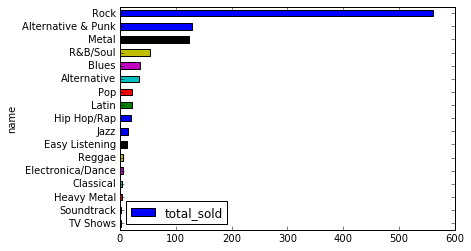

In [43]:
genre_data = run_query(query_genres).set_index('name')
genre_data.sort_values('total_sold').plot.barh(y='total_sold')

Rock, metal, and alternative music are the vast majority of sales. Therefore, the priority should be to add Red Tone, a punk band, to the store. Regal, the hip-hop artist, should be the one excluded.

## Find out if any agent is performing better or worse
To do this, we sum the total dollar amount of sales corresponding to each agent, by joining the invoices to the customer and employee tables, which give us some additional info such as country, age, and time in the company.

In [53]:
query_agent = """
SELECT
    e.first_name || " " || e.last_name employee_name,
    e.country,
    e.birthdate,
    e.hire_date,
    TOTAL(i.total) total_sales
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY 1
"""
run_query(query_agent)

,employee_name,country,birthdate,hire_date,total_sales
0,Jane Peacock,Canada,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51
1,Margaret Park,Canada,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Canada,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92


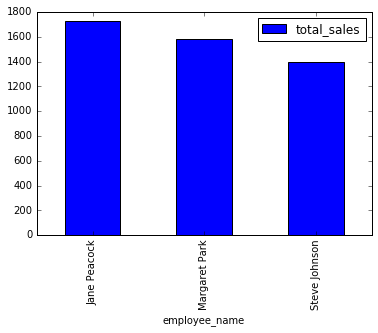

In [50]:
employee_data = run_query(query_agent).set_index('employee_name')
employee_data.plot.bar()

The three employees dont have too different sales results, but the one hired earliest as the most sales, as expected.

## Analyzing sales by country
Will now analyze the total number of customers, sales, and averages for each country. Countries with just one customer will be regrouped as "Other".

In [82]:
query_country = """
WITH all_countries AS
    (SELECT
        c.country,
        COUNT(DISTINCT(c.customer_id)) total_customers,
        TOTAL(i.total) total_sales,
        COUNT(DISTINCT(i.invoice_id)) total_invoices
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1),
    
    regroup AS
    (SELECT
        CASE
            WHEN total_customers = 1 THEN "Other"
            ELSE country
        END 
        AS country_regrouped,
        a.country,
        a.total_customers,
        a.total_sales,
        a.total_invoices
    FROM all_countries a),
    
    add_up AS
    (SELECT 
        country_regrouped,
        SUM(total_customers) total_customers,
        SUM(total_sales) total_sales,
        CASE
            WHEN country_regrouped = 'Other' THEN 1
            ELSE 0
            END as sorting_col,
        SUM(total_invoices) total_invoices
    FROM regroup
    GROUP BY 1
    ORDER BY 3 DESC
    )    

SELECT 
    country_regrouped country,
    total_customers,
    total_sales,
    total_sales / total_customers avg_sale_customer,
    total_sales / total_invoices avg_order_value
FROM add_up
ORDER BY sorting_col

"""
run_query(query_country)

,country,total_customers,total_sales,avg_sale_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


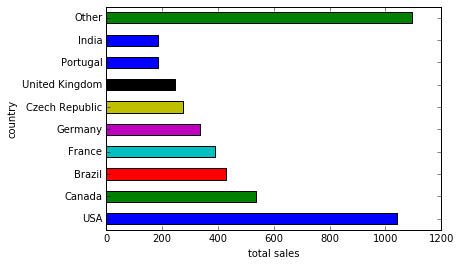

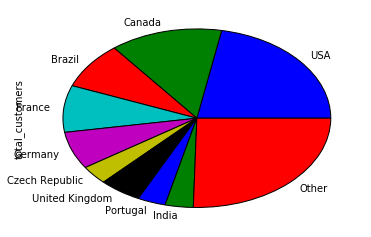

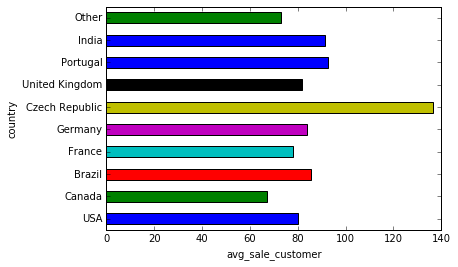

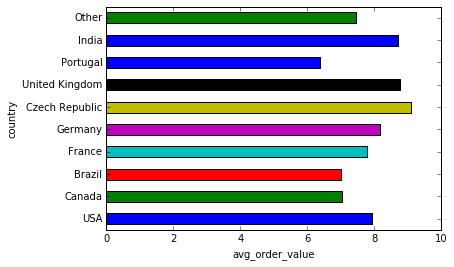

In [95]:
country_data = run_query(query_country).set_index('country')
country_data.plot.barh(y = 'total_sales', legend=None).set_xlabel('total sales')
country_data.plot.pie(y='total_customers', legend=None)
country_data.plot.barh(y = 'avg_sale_customer', legend=None).set_xlabel('avg_sale_customer')
country_data.plot.barh(y = 'avg_order_value', legend=None).set_xlabel('avg_order_value')

Czech republic may offer potential for growth -- polish plots later

## Albums vs Tracks
Let's find out if each invoice was either an album purchase or not. To do this, we compare the list of tracks in an invoice to the list of tracks in an album.

In [145]:
query_purchase = """
WITH invoice_first_album AS
    (SELECT
        il.invoice_id,
        MIN(al.album_id) invoice_album
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album al ON al.album_id = t.album_id
    GROUP BY invoice_id
    ),
    
    comparison AS
    (SELECT
        ifa.invoice_id,
        CASE
            WHEN (
            ((
                    SELECT track_id
                    FROM track
                    WHERE album_id = ifa.invoice_album
                EXCEPT
                    SELECT track_id
                     FROM invoice_line
                     WHERE invoice_id = ifa.invoice_id
                ) 
                IS NULL)
            AND
            ((
                SELECT track_id
                 FROM invoice_line
                 WHERE invoice_id = ifa.invoice_id
                     EXCEPT
                 SELECT track_id
                    FROM track
                    WHERE album_id = ifa.invoice_album
                ) 
                IS NULL))
                THEN "yes, album"
                ELSE "not album"
        END AS album_purchase
    FROM invoice_first_album ifa)

SELECT 
    album_purchase,
    COUNT(album_purchase) total,
    CAST(COUNT(album_purchase) AS FLOAT) / (SELECT COUNT(*) FROM comparison) percentage
FROM comparison
GROUP BY 1"""
run_query(query_purchase)

,album_purchase,total,percentage
0,not album,500,0.814332
1,"yes, album",114,0.185668


Most sales are not full albums, it might save money to no longer buy full albums. Would have to dig deeper t